# Analysis of fragmented malware detection by Suricata

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import re
from collections import defaultdict

import orjson

In [164]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)


In [165]:
def get_json_data(file):
    return [orjson.loads(line) for line in open("suricata_logs/All.ElectroRAT/eve.json", "rb")]

In [166]:
def get_alerts(json_data):
    alerts = [line for line in json_data if "alert" in line]
    return alerts

In [176]:
def plot_alerts(data):    
    nmbr_signatures = defaultdict(int)
    for entry in data:
        nmbr_signatures[entry['alert']['signature']] += 1

    x_ticks = [i for i in nmbr_signatures.keys()]
    xlabels_new = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in x_ticks]
    
    fig, ax = plt.subplots()
    
    ax.set_xticks(np.arange(len(nmbr_signatures)), xlabels_new)
    ax.set_ylabel('Number of alerts')
    ax.set_xlabel('Alert name')
    ax.set_title('Number of alerts in file')
    ax.bar(np.arange(len(nmbr_signatures)), nmbr_signatures.values())


In [177]:
file = "suricata_logs/All.ElectroRAT/eve.json"
json_data = get_json_data(file)
alerts = get_alerts(json_data)

AttributeError: 'AxesSubplot' object has no attribute 'show'

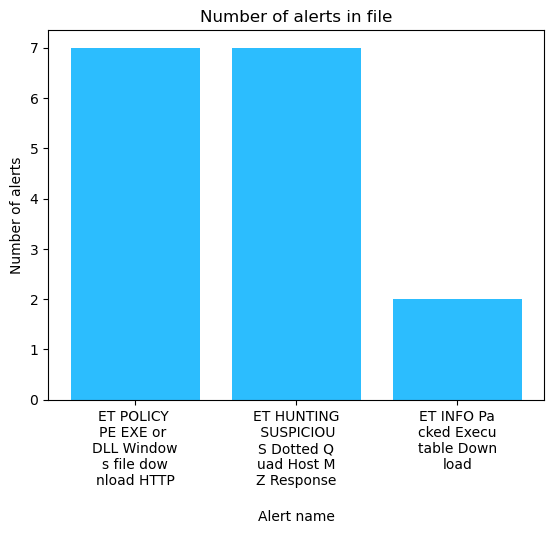

In [178]:
plot_alerts(alerts)

In [152]:
alerts

[{'timestamp': '2023-01-24T11:25:31.089421+0100',
  'flow_id': 828781352393948,
  'pcap_cnt': 330,
  'event_type': 'alert',
  'src_ip': '172.17.0.2',
  'src_port': 8000,
  'dest_ip': '172.17.0.1',
  'dest_port': 43622,
  'proto': 'TCP',
  'metadata': {'flowbits': ['http.dottedquadhost', 'ET.http.binary']},
  'tx_id': 0,
  'alert': {'action': 'allowed',
   'gid': 1,
   'signature_id': 2018959,
   'rev': 4,
   'signature': 'ET POLICY PE EXE or DLL Windows file download HTTP',
   'category': 'Potential Corporate Privacy Violation',
   'severity': 1,
   'metadata': {'created_at': ['2014_08_19'],
    'former_category': ['POLICY'],
    'updated_at': ['2017_02_01']}},
  'http': {'hostname': '172.17.0.2',
   'http_port': 8000,
   'url': '/All.ElectroRAT/2a3b92f6180367306d750e59c9b6446b00000',
   'http_user_agent': 'curl/7.81.0',
   'http_content_type': 'application/octet-stream',
   'http_method': 'GET',
   'protocol': 'HTTP/1.1',
   'status': 200,
   'length': 15577},
  'files': [{'filename':

[2018959, 2021076, 2014819]
['ET POLICY PE EXE or DLL Windows file download HTTP', 'ET HUNTING SUSPICIOUS Dotted Quad Host MZ Response', 'ET INFO Packed Executable Download']


NameError: name 'langs' is not defined

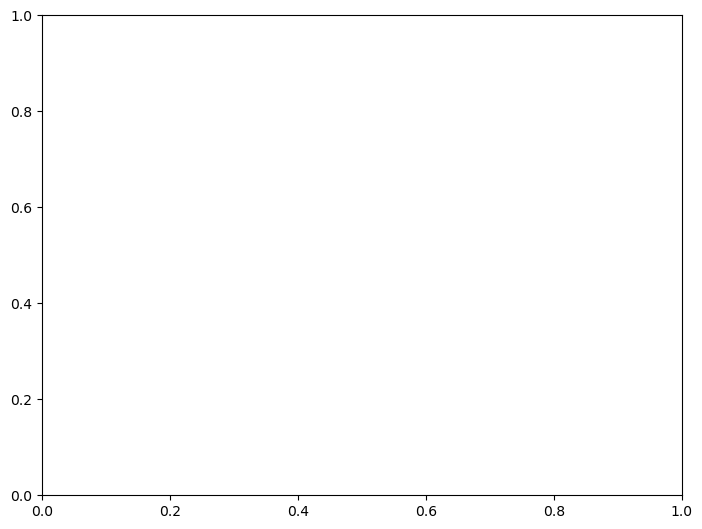

In [66]:
visualize_alerts(alerts)

In [47]:
alerts

[{'timestamp': '2023-01-24T11:25:31.089421+0100',
  'flow_id': 828781352393948,
  'pcap_cnt': 330,
  'event_type': 'alert',
  'src_ip': '172.17.0.2',
  'src_port': 8000,
  'dest_ip': '172.17.0.1',
  'dest_port': 43622,
  'proto': 'TCP',
  'metadata': {'flowbits': ['http.dottedquadhost', 'ET.http.binary']},
  'tx_id': 0,
  'alert': {'action': 'allowed',
   'gid': 1,
   'signature_id': 2018959,
   'rev': 4,
   'signature': 'ET POLICY PE EXE or DLL Windows file download HTTP',
   'category': 'Potential Corporate Privacy Violation',
   'severity': 1,
   'metadata': {'created_at': ['2014_08_19'],
    'former_category': ['POLICY'],
    'updated_at': ['2017_02_01']}},
  'http': {'hostname': '172.17.0.2',
   'http_port': 8000,
   'url': '/All.ElectroRAT/2a3b92f6180367306d750e59c9b6446b00000',
   'http_user_agent': 'curl/7.81.0',
   'http_content_type': 'application/octet-stream',
   'http_method': 'GET',
   'protocol': 'HTTP/1.1',
   'status': 200,
   'length': 15577},
  'files': [{'filename':